In [1]:
from scipy.integrate import quad, trapz, fixed_quad
import theano
import theano.tensor as T
from theano.tests.unittest_tools import verify_grad
from theano.compile.ops import as_op

import numpy as np
import pymc3 as pm

import matplotlib.pyplot as plt

import astropy.units as u
from astropy.coordinates import SkyCoord

from tqdm import tqdm

from gammapy.spectrum import CountsPredictor, CountsSpectrum
from gammapy.data import DataStore
from gammapy.maps import Map
from gammapy.background import ReflectedRegionsBackgroundEstimator
from gammapy.spectrum import SpectrumObservationList
from gammapy.data import DataStore
from gammapy.spectrum import SpectrumObservationList
from gammapy.maps import Map
from gammapy.background import ReflectedRegionsBackgroundEstimator
from gammapy.spectrum import SpectrumExtraction

from scipy.ndimage import filters 

from regions import CircleSkyRegion

from utils import load_spectrum_observations, plot_spectra, Log10Parabola, integrate_spectrum, wstat_profile
from forward_fold_model import model_probability, ln_profile_likelihood

%matplotlib inline

In [2]:
import gammapy
gammapy.__version__

'0.9'

In [3]:
crab_position = SkyCoord(ra='83d37m59.0988s', dec='22d00m52.2s')
exclusion_map = Map.read(f"./data/exclusion_mask.fits.gz")

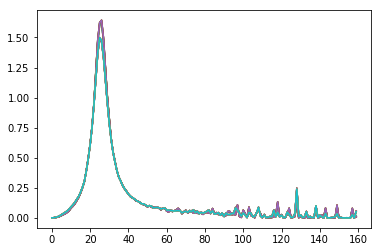

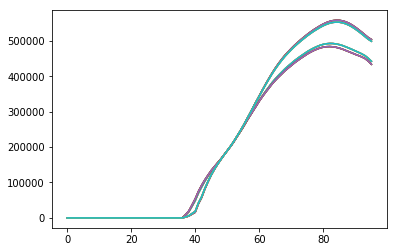

In [111]:
telescope = 'hess'

energy_range = {
    'fact': [0.58, 12] * u.TeV,
    'magic': [0.05, 12] * u.TeV,
    'veritas': [0.12, 15] * u.TeV,
    'hess': [0.34, 20] * u.TeV,
}

on_radius = {
    'fact': 0.17 * u.deg,
    'magic': 0.142 * u.deg,
    'veritas': 0.10 * u.deg,
    'hess': 0.11 * u.deg,
}
ds = DataStore.from_dir(f'./data/{telescope}/')
observations = ds.get_observations(ds.hdu_table['OBS_ID'].data)

for obs in observations:
    plt.plot(obs.edisp.data.data.value.mean(axis=0)[:, 0])
    
plt.figure()

for obs in observations:
    plt.plot(obs.aeff.data.data.value.mean(axis=1))

In [112]:
# fit_range = [0.6, 30] * u.TeV
fit_range = energy_range[telescope]
# print(fit_range)
e_true_bins = np.logspace(*np.log10(fit_range.value), 12 + 1)
# e_true_bins[0] = 0.0001 * u.TeV
# e_true_bins[-1] = 1000 * u.TeV
# e_true_bins = np.append(e_true_bins, 1000) 
e_reco_bins = np.logspace(*np.log10(fit_range.value), 14 + 1)
# e_reco_bins[0] = 0.0001 * u.TeV
# e_reco_bins = np.append(e_reco_bins, 1000) 

e_reco_bins *= u.TeV
e_true_bins *= u.TeV

e_reco_bins

<Quantity [ 0.34      ,  0.45485757,  0.6085159 ,  0.81408253,  1.08909293,
            1.45700635,  1.94920695,  2.60768096,  3.48859828,  4.66710388,
            6.24372797,  8.35296148, 11.1747286 , 14.94973485, 20.        ] TeV>

In [113]:
on_region = CircleSkyRegion(center=crab_position, radius=on_radius[telescope])

print('Estimating Background')
bkg_estimate = ReflectedRegionsBackgroundEstimator(
    observations=observations, on_region=on_region, exclusion_mask=exclusion_map
)
bkg_estimate.run()

print('Extracting Count Spectra')
extract = SpectrumExtraction(
    observations=observations,
    bkg_estimate=bkg_estimate.result,
    e_true=e_true_bins,
    e_reco=e_reco_bins,
    containment_correction=False,
    use_recommended_erange=False,
)

extract.run()


Estimating Background
Extracting Count Spectra


In [114]:
stacked_observation = extract.spectrum_observations.stack()

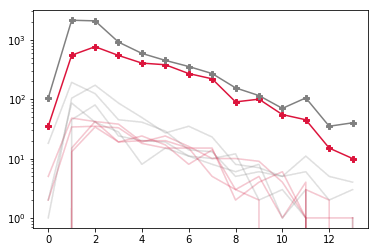

In [115]:
spectrum_observations = extract.spectrum_observations
# print(len(spectrum_observations))
for obs in spectrum_observations:
    plt.plot(obs.on_vector.data.data, color='crimson', alpha=0.05)
    plt.plot(obs.off_vector.data.data, color='gray', alpha=0.05)
    
# on_data, off_data = get_observed_counts(spectrum_observations)

# plt.plot(on_data, color='crimson')
# plt.plot(off_data, color='gray', )

plt.plot(stacked_observation.on_vector.data.data, color='crimson', marker='P' )
plt.plot(stacked_observation.off_vector.data.data, color='gray', marker='P')
plt.yscale('log')
# obs.on_vector.data.data.shape, obs.off_vector.data.data.shape

In [116]:
def response(mu_sig, edisp, efficiency=1, fit_range=None, ):
    edisp = edisp.pdf_matrix * efficiency
    counts = T.dot(mu_sig, edisp)
    return counts

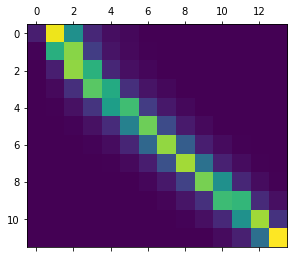

<Figure size 432x288 with 0 Axes>

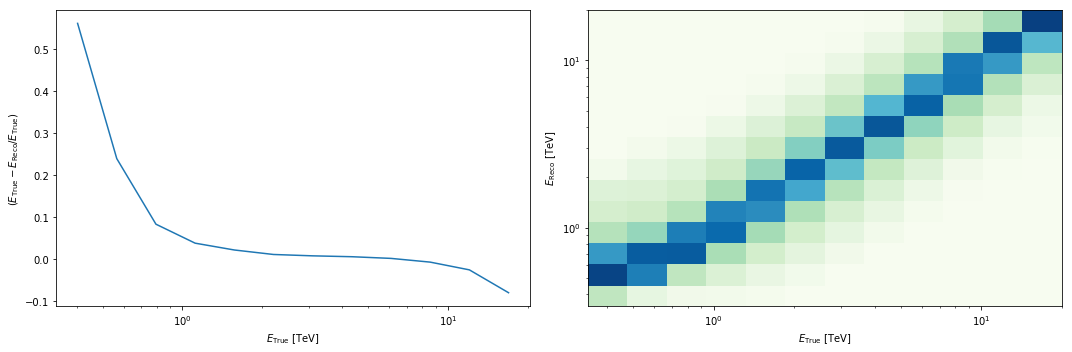

In [117]:
plt.matshow(stacked_observation.edisp.pdf_matrix)
plt.figure()
stacked_observation.edisp.peek()

In [118]:

laplace_matrix = filters.laplace(np.eye(len(stacked_observation.edisp.e_true.lo))) // 2

def thikonov(f, normalize=False):
    if normalize:
        f = f/f.sum()
    a = T.dot(laplace_matrix, f)
    a_transposed = a.T 
    return T.dot(a, a_transposed)

In [131]:
on_data = stacked_observation.on_vector.data.data.value
off_data = stacked_observation.off_vector.data.data.value
exposure_ratio = stacked_observation.alpha[0] 
aeff = stacked_observation.aeff.data.data

N_true = len(stacked_observation.edisp.e_true.lo)
N_reco = len(stacked_observation.edisp.e_reco.lo)

tau=0.1

model = pm.Model(theano_config={'compute_test_value': 'ignore'})
with model:
    mu_b = pm.Uniform('mu_b', shape=len(off_data), upper=2* off_data.max(), lower=0)
    mu_s = pm.Uniform('mu_s', shape=len(stacked_observation.edisp.e_true.lo), upper=10000, lower=0)

#     tau = pm.HalfNormal('tau', sd=5)
#     mu_b = pm.TruncatedNormal('mu_b', sd=20, shape=len(off_data), lower=0)
#     mu_s = pm.TruncatedNormal('mu_s', sd=5, shape=len(stacked_observation.edisp.e_true.lo), lower=0)
    efficiency = pm.Normal('epsilon', mu=1, sd=0.15, shape=N_true)
    expected_counts = response(efficiency * mu_s, edisp=stacked_observation.edisp)
    
    if tau > 0:
        lam = thikonov(pm.math.log(mu_s), normalize=False)
        logp = pm.Normal.dist(mu=0, sd=1/tau).logp(lam) 
        p = pm.Potential("thikonov", logp)    


    #     print(expected_counts.shape)
    b = pm.Poisson('background', mu=mu_b, observed=off_data)    
    s = pm.Poisson('signal', mu = expected_counts + exposure_ratio * mu_b, observed=on_data)
    

In [132]:
model.test_point, 

({'mu_b_interval__': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  'mu_s_interval__': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  'epsilon': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])},)

In [133]:
with model:
#     step1 = pm.Metropolis([mu_b])
#     step2 = pm.NUTS([amplitude, alpha, beta], target_accept=0.9)
#     trace = pm.sample(1000, step=[step1, step2], chains=5, cores=5)
    trace = pm.sample(1500, chains=5, cores=5, init='auto', target_accept=0.95, tune=2500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [epsilon, mu_s, mu_b]
Sampling 5 chains: 100%|██████████| 20000/20000 [00:20<00:00, 956.34draws/s] 


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f73e8ee3860>,
      dtype=object)

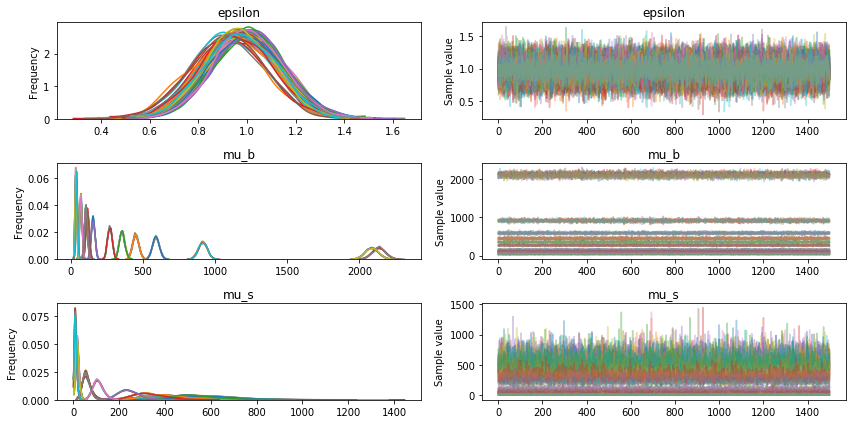

In [134]:
pm.traceplot(trace)

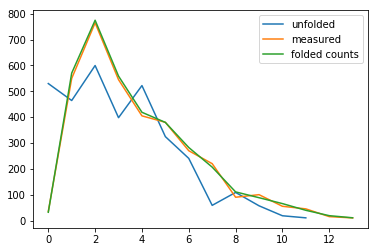

In [135]:
# plt.plot(map_estimate['mu_b'])
f = np.median(trace['mu_s'], axis=0)
b = np.median(trace['mu_b'], axis=0)
plt.plot(f, label='unfolded')

expected_counts = np.dot(f, stacked_observation.edisp.pdf_matrix)
plt.plot(on_data, label='measured')
plt.plot(expected_counts + exposure_ratio*b, label='folded counts')
plt.legend()

[5.27896831e-11 3.12251470e-11 1.06715442e-11 8.92225788e-12
 3.10087089e-12 1.41319368e-12 1.71649184e-13 2.40940608e-13
 7.46672412e-14 1.31809514e-14] [9.34420117e-11 4.42244142e-11 1.56434152e-11 1.18955829e-11
 4.32336425e-12 1.91688048e-12 2.90576583e-13 3.48569535e-13
 1.22315283e-13 2.68009458e-14] [1.46511697e-10 6.16622093e-11 2.26899193e-11 1.61599300e-11
 6.20644183e-12 2.63369755e-12 4.93188491e-13 4.93234901e-13
 1.90088668e-13 4.82694096e-14]


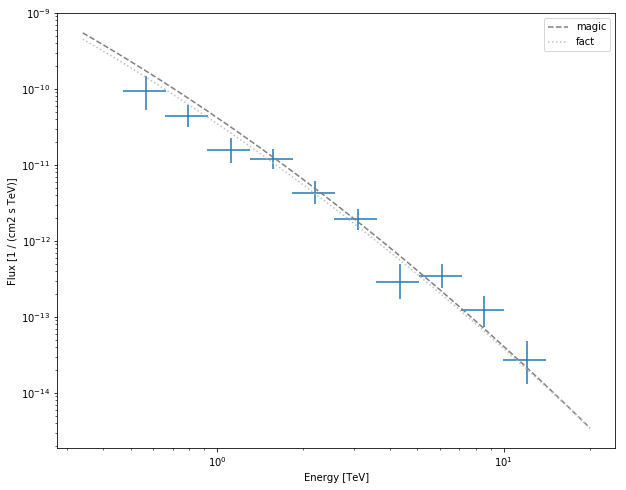

In [136]:
observation = stacked_observation

magic_model = Log10Parabola(
    amplitude=4.20 * 1e-11 * u.Unit('cm-2 s-1 TeV-1'),
    reference=1 * u.Unit('TeV'),
    alpha=2.58 * u.Unit(''),
    beta=0.43 * u.Unit(''),
)

fact_model = Log10Parabola(
    amplitude=3.5 * 1e-11 * u.Unit('cm-2 s-1 TeV-1'),
    reference=1 * u.Unit('TeV'),
    alpha=2.56* u.Unit(''),
    beta=0.4 * u.Unit(''),
)

e_center = stacked_observation.edisp.e_true.log_center().to_value(u.TeV)[1:-1]
bin_width = stacked_observation.edisp.e_true.bin_width.to_value(u.TeV)[1:-1]

norm = 1 / stacked_observation.aeff.data.data / stacked_observation.livetime / stacked_observation.edisp.e_true.bin_width
norm = norm[1:-1]
flux = trace['mu_s'][:, 1:-1] * norm
mean_flux = np.median(flux, axis=0).to_value(1 / (u.TeV * u.s * u.cm**2))
lower, upper = np.percentile(flux, [5, 95], axis=0)

dl = mean_flux - lower
du = upper - mean_flux
print(lower, mean_flux, upper)

# # flux = s * observation.edisp.e_true.log_center()**2
# # mle_model.plot(energy_range=fit_range, ls='--', color='red', label='magic paper', energy_power=2)
# # plt.plot(e_center, flux.to_value(u.TeV / (u.s * u.cm**2)), '.')

# # plt.figure()
# # flux = s * observation.edisp.e_true.log_center()**1
# # mle_model.plot(energy_range=fit_range, ls='--', color='red', label='magic paper', energy_power=1)
# # plt.plot(e_center, flux.to_value(1 / (u.s * u.cm**2)), '.')

plt.figure(figsize=(10, 8))
magic_model.plot(energy_range=fit_range, ls='--', color='gray', label='magic')
fact_model.plot(energy_range=fit_range, ls=':', color='silver', label='fact')
# plt.plot(e_center, flux.to_value(1 / (u.TeV * u.s * u.cm**2)), '.')
plt.errorbar(e_center, mean_flux, yerr=[dl, du],  xerr=bin_width/2, linestyle='')

plt.legend()
# plt.figure(figsize=(10, 3))
# plt.plot(lower)
# plt.plot(upper)
# plt.yscale('log')


# plt.figure(figsize=(10, 3))
# plt.plot(np.std(trace['mu_s'], axis=0)[1:-1] * norm)
# # plt.yscale('log')

# observation.edisp.e_true.log_center()

In [108]:
with model:
    samples = pm.sample_ppc(trace)

100%|██████████| 1500/1500 [00:01<00:00, 939.42it/s] 


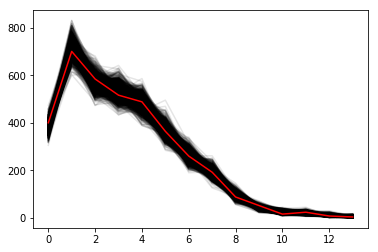

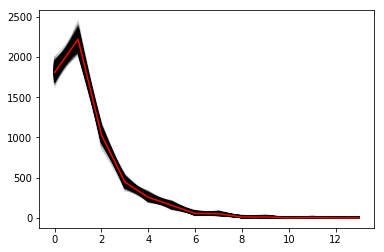

In [98]:
plt.figure()
plt.plot(samples['signal'].T, color='k', alpha=0.1)
plt.plot(on_data , color='red')

plt.figure()
plt.plot(samples['background'].T, color='k', alpha=0.1)
plt.plot(off_data, color='red')

None

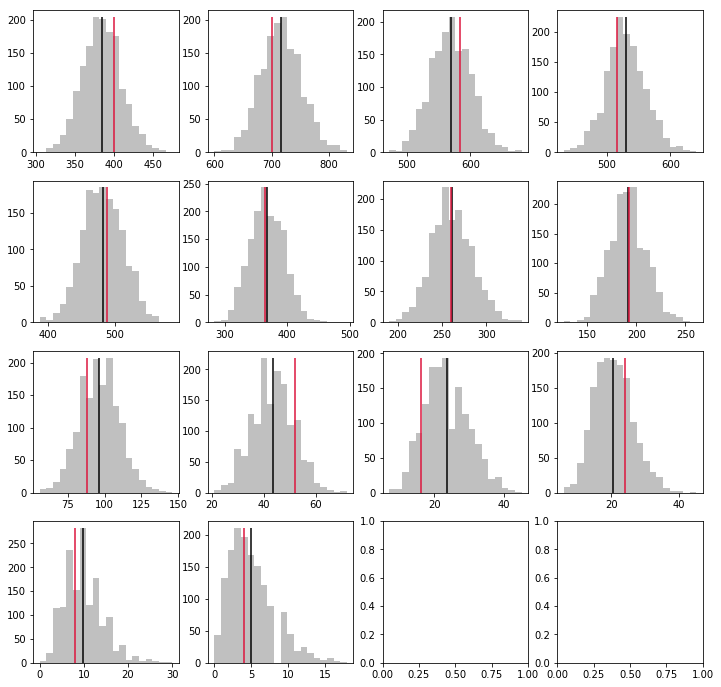

In [99]:
fig, axs = plt.subplots(4, 4, figsize=(12, 12))
for s, signal, ax in zip(samples['signal'].T, on_data, axs.ravel()):
    h, _,_ =  ax.hist(s, bins=20, lw=2, color='silver')
    ax.vlines(s.mean(), ymin=0, ymax=h.max())
    ax.vlines(signal, ymin=0, ymax=h.max(), color='crimson')
    

In [100]:
# display the total number and percentage of divergent
divergent = trace['diverging']
print('Number of Divergent %d' % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size / len(trace) * 100
print('Percentage of Divergent %.1f' % divperc)

Number of Divergent 0
Percentage of Divergent 0.0


In [101]:
pm.summary(trace).round(3)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
epsilon__0,0.990,0.100,0.001,0.803,1.187,11364.601,1.000
epsilon__1,0.990,0.098,0.001,0.808,1.188,16308.540,1.000
epsilon__2,0.989,0.100,0.001,0.794,1.188,10377.515,1.000
epsilon__3,0.991,0.101,0.001,0.804,1.192,9644.008,1.000
epsilon__4,0.989,0.101,0.001,0.799,1.193,9501.072,1.000
epsilon__5,0.992,0.102,0.001,0.797,1.192,9416.721,1.000
epsilon__6,0.991,0.100,0.001,0.795,1.185,9551.772,1.001
epsilon__7,0.991,0.102,0.001,0.799,1.195,14398.847,1.000
epsilon__8,0.991,0.102,0.001,0.786,1.185,17106.363,1.000
epsilon__9,0.991,0.102,0.001,0.783,1.178,17471.039,1.000
